In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity # 코사인유사도

**아이템기반 협업필터링(베이스라인)**


---



**데이터 준비**

In [ ]:
filename = '/content/MyDrive/MyDrive/codestates/cp2/df_model.csv'  # 고객 분류한 데이터(model_df) 불러오기
df_model = pd.read_csv(filename) # count 기준 purchase 3, cart에 넣으면 2, view면 1
df_model.head()

,Unnamed: 0,user_id,product_id,event_type,count
0,31964969,33869381,7002639,view,1
1,15808538,64078358,10600284,view,1
2,2420043,183503497,22200103,view,1
3,4800257,184265397,6902133,view,1
4,20219228,184265397,27400002,view,1


In [ ]:
df_model.drop(['Unnamed: 0'], axis = 1, inplace = True) # Unnamed 삭제
df_model.head()

,user_id,product_id,event_type,count
0,33869381,7002639,view,1
1,64078358,10600284,view,1
2,183503497,22200103,view,1
3,184265397,6902133,view,1
4,184265397,27400002,view,1


In [ ]:
df_model['event_type'].value_counts()

view        40779399
cart          926516
purchase      742849
Name: event_type, dtype: int64

In [ ]:
df_model['event_type'].count() # 전체 데이터 개수

42448764

([<matplotlib.patches.Wedge at 0x7f987e16c4d0>,
 [Text(-1.1412342968472802, 0.1417190167179207, 'view'),
  Text(1.1317226083454177, -0.20421541998547563, 'cart'),
  Text(1.1482624979220948, -0.0631920554002737, 'purchase')],
 [Text(-0.6450454721310713, 0.08010205292752039, '96.1%'),
  Text(0.6396693003691492, -0.1154261069483123, '2.2%'),
  Text(0.6490179336081405, -0.035717248704502526, '1.7%')])

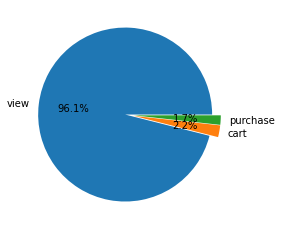

In [ ]:
# view, purchase, cart 비율 파이 차트

ratio = [40779399, 926516, 742849] # 
labels = ['view', 'cart', 'purchase']
explode = [0.05, 0.05, 0.05]

plt.pie(ratio, labels = labels,autopct = '%.1f%%', explode = explode) # 96.1%, 2.2%, 1.7%

In [ ]:
# 원활한 모델링을 위한 데이터 축소(약 10만개로)

print(40779399 * 1/400, 926516 * 1/400, 742849 * 1/400) # 축소할 데이터 비율

101948.4975 2316.29 1857.1225


In [ ]:
view_model = df_model[df_model['event_type'] == 'view'].head(101948) # 축소한 view 타입 데이터 양
cart_model = df_model[df_model['event_type'] == 'cart'].head(2316) # 축소한 cart 타입 데이터 양
purchase_model = df_model[df_model['event_type'] == 'purchase'].head(1857) # 축소한 purchase 타입 데이터 양

a = pd.concat([view_model,cart_model,purchase_model])
a

,user_id,product_id,event_type,count
0,33869381,7002639,view,1
1,64078358,10600284,view,1
2,183503497,22200103,view,1
3,184265397,6902133,view,1
4,184265397,27400002,view,1
...,...,...,...,...
241533,512375299,23900299,purchase,3
241641,512375312,4803977,purchase,3
241648,512375312,1004249,purchase,3
241718,512375334,3701387,purchase,3


In [ ]:
data = a

**데이터 모델링**

In [ ]:
# 데이터 피봇
ratings = data.pivot_table(index='product_id', columns='user_id',values='count') # 피봇
ratings

user_id,33869381,64078358,183503497,184265397,195082191,200673532,205053188,208669541,209714031,210507313,...,512375136,512375160,512375169,512375243,512375245,512375263,512375293,512375299,512375312,512375334
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58300001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58300008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ratings = ratings.fillna(0) # 결측치 0으로
ratings

user_id,33869381,64078358,183503497,184265397,195082191,200673532,205053188,208669541,209714031,210507313,...,512375136,512375160,512375169,512375243,512375245,512375263,512375293,512375299,512375312,512375334
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58300001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58300008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 아이템 간 코사인 유사도 구하기

item_based_collabor = cosine_similarity(ratings)
item_based_collabor

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.70710678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.70710678, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# 아이템 별 서로 유사한 정도(자신과 일치하는 값은 1)
item_based_collabor = pd.DataFrame(data = item_based_collabor, index = ratings.index, columns = ratings.index)
item_based_collabor

product_id,1000978,1001588,1002062,1002098,1002099,1002100,1002101,1002102,1002225,1002266,...,56900002,56900004,57000001,57600004,57600031,58000000,58300001,58300008,58300010,60500002
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,1.0,0.000000,0.0,0.000000,0.000000,0.288675,0.103695,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1001588,0.0,1.000000,0.0,0.000000,0.073721,0.000000,0.089803,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1002062,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1002098,0.0,0.000000,0.0,1.000000,0.167183,0.188982,0.271538,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1002099,0.0,0.073721,0.0,0.167183,1.000000,0.000000,0.185369,0.111456,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0
58300001,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.707107,0.000000,0.0
58300008,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,1.000000,0.707107,0.0


In [ ]:
# 마음에 드는 물건과 유사한 물건 추천
# 본인을 뺀 5개 까지 추천

def get_item_based_collabor(product_id) :
  a = item_based_collabor[product_id].sort_values(ascending = False)[:6]
  for d in range(5) :
    if a.index[d] == product_id :
      a.drop(product_id, inplace = True)
  
  return a

In [ ]:
get_item_based_collabor(8500084) # 본인 빠졋는지 확인

product_id
45601506    1.000000
27700136    1.000000
8500083     0.755689
8500081     0.577350
8500086     0.447214
Name: 8500084, dtype: float64

**평가지표**

In [ ]:
data_pca = data[data['event_type'] == 'purchase'] # data 중 구매한 데이터만 뽑기
data_pca.sort_values(by = 'user_id', inplace = True) # user_id 기준 정렬 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
data_view = data[data['event_type'] == 'view'] # data 중 view한 데이터만 뽑기
data_view.sort_values(by = 'user_id', inplace = True) # user_id 기준 정렬 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
data_cart = data[data['event_type'] == 'cart'] # data 중 카트에 넣은 데이터만 뽑기
data_cart.sort_values(by = 'user_id', inplace = True) # user_id 기준 정렬 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
user_pca = data_pca['user_id'].unique() # purchase 타입 고유 유저
user_pca

array([264649825, 303160429, 340041246, 371877401, 384989212, 387300134,
       396222093, 401021311, 401646272, 403013066, 410333972, 413782099,
       415153398, 415873351, 418115333, 419697235, 420935067, 424869855,
       425101109, 427151532, 427391662, 427908425, 429474454, 430524990,
       431246706, 431897261, 433265970, 433754231, 434170823, 434350078,
       434715713, 435648894, 435786120, 437371552, 438866867, 438992161,
       439111345, 440471930, 440756116, 440789264, 441522689, 441538541,
       444316141, 445228646, 446080337, 447473754, 447698613, 450275087,
       450756413, 451868425, 451971397, 452690313, 452958129, 453705583,
       453908841, 454052851, 454108351, 454170074, 454959751, 455460477,
       455760356, 456575945, 456810531, 457360398, 458020849, 458133649,
       458443142, 458524195, 458842641, 459629038, 459898402, 460201436,
       460337720, 460983696, 461023190, 461956439, 462288298, 462757549,
       465723791, 465832070, 466355604, 467356718, 

In [ ]:
user_view = data_view['user_id'].unique() # view 타입 고유 유저 수

In [302]:
# purchase, cart 합치기
data_a = pd.concat([data_pca,data_cart])
data_a.sort_values(by = 'user_id', inplace = True) # user_id 기준 정렬 
data_a

In [ ]:
user_a = data_a['user_id'].unique() # cart, purchase 타입 유저 합한 고유 유저 수

In [ ]:
data_a['user_id'].value_counts()

512364323    58
512372673    55
512371555    51
512365112    42
512371090    40
             ..
489487999     1
489480973     1
489355459     1
512365189     1
479012788     1
Name: user_id, Length: 1385, dtype: int64

In [297]:
# 유저별 아이템 추천 알고리즘
result = pd.DataFrame() # 결과 데이터프레임 객체 생성
result['user_id'] = user_a # 결과 데이터프레임 user 컬럼 생성

a = [] # 리스트 객체 생성
b = [] 
c = []

for usr in tqdm(user_a, desc = 'user 아이템 추천') : 
  temp = data_a.query('user_id == @usr') # 해당 user 데이터 추출
  a = temp.loc[:,'product_id'].to_list()[:58] # 사용자가 구매한 아이템 추출
  for r in range(len(a)) :
    b.append(get_item_based_collabor(a[r]).index.to_list()[:5]) # 추천목록 뽑아내기
  c.append(b)
  b = [] # b list 초기화
result['recommend'] = c

user 아이템 추천: 100%|██████████| 1385/1385 [00:18<00:00, 76.85it/s]


In [299]:
# 알고리즘 결과 데이터프레임

result

,user_id,recommend
0,264649825,"[[8500081, 27700136, 45601506, 8500084, 850027..."
1,284344819,"[[1002525, 1002535, 1005131, 1005113, 5100573]]"
2,293957954,"[[1005160, 1005159, 1004739, 1004775, 1005031]]"
3,303160429,"[[1000978, 19200070, 19200062, 19200049, 19200..."
4,304325717,"[[1004489, 28715751, 5000346, 1004852, 1004284..."
...,...,...
1380,512375263,"[[1000978, 19200020, 19200062, 19200049, 19200..."
1381,512375293,"[[1004246, 1004258, 1005115, 1004250, 1004252]]"
1382,512375299,"[[23900299, 23900286, 1000978, 19200009, 19200..."
1383,512375312,"[[37900152, 1701268, 6600619, 14400051, 480405..."


In [300]:
data_a[data_a['user_id']==284344819] # 데이터 잘 들어갔는지 확인

,user_id,product_id,event_type,count
604,284344819,1005122,cart,2


In [ ]:
get_item_based_collabor(1005122) # 데이터 잘 들어갔는지 확인

product_id
1002525    0.207020
1002535    0.126773
1005131    0.117897
1005113    0.108415
5100573    0.103510
Name: 1005122, dtype: float64

In [ ]:
result.loc[1]['recommend'] # 확인

[[1002525, 1002535, 1005131, 1005113, 5100573]]

In [ ]:
len(result.loc[0]['recommend'])

2

In [ ]:
user = data_a['user_id'].unique() # data_a 고유유저
len(user)

1385

In [ ]:
# 평가지표 
def result_evaluation(result) : #result 데이터프레임 넣기
  item_total = 0 # 전체 추천 아이템 개수 초기화
  user_item = 0 # 추천한 아이템 중 사용자가 관심있어하는 아이템 개수 초기화
  real_user_item = 0 # 실제로 사용자가 관심있어하는 개수 초기화

  for r in tqdm(range(result['user_id'].count()), desc = 'precision 구하기') :
    item_total += len(result.loc[r]['recommend']) * 5 # 5개의 아이템을 추천하므로 곱하기 5 해준다
    for f in range(len(result.loc[r]['recommend'])) :
      condition = result.loc[r]['user_id']
      sd =  data_a.query('user_id == @condition')['product_id'].to_list() # 해당유저가 아이템을 사거나 cart에 넣었는지 확인
      for d in range(5) :
        if result.loc[r]['recommend'][f][d] in sd :
          user_item += 1
  
  # 실제로 사용자가 관심있어하는 product
  for usr in tqdm(user) :
    temp = data_a.query('user_id == @usr')
    a = temp['product_id'].to_list()
    real_user_item += len(a)
  
  precision = user_item / item_total # 추천한 아이템 중 사용자가 관심있어하는 아이템 개수 / 전체 추천한 아이템 개수
  recall = user_item / real_user_item
  return print(f"precision : {precision}, recall : {recall}")

In [ ]:
result_evaluation(result)

100%|██████████| 1385/1385 [00:02<00:00, 515.56it/s]

precision : 0.24624970045530792, recall : 1.2312485022765396


In [303]:
precision = 0.24
recall = 1.23
print(precision , recall)

0.24 1.23
